# Deterministic Linear Transport equation
---
Consider the equation
$$
\left\{
\begin{aligned}
&\frac{\partial r}{\partial t} + v\frac{\partial j}{\partial x} = \frac{\sigma(x, z)}{\epsilon^2}(\hat{r} - r), \\
&\frac{\partial j}{\partial t} + \frac{v}{\epsilon^2}\frac{\partial r}{\partial x} = - \frac{\sigma(x, z)}{\epsilon^2}j, 
\end{aligned}
\right.
$$
where $\epsilon$ is a small number, $v \in [-1, 1]$, and $\hat{r} = \int_{0}^{1} rdv$. 

It seems to me that $v$ follows a uniform distribution (as Gauss-Legendre quadrature is used to compute the integral).

We let $\sigma(x, z) \equiv 1$.

The initial data are
$$
r(x, v, z, t = 0) = j(x, v, z, t = 0) = 0.
$$

BC: for all $v, x, t$,
$$
\sigma j = -v r_{x}, 
$$
and for all $v$, 
$$
r - \frac{\epsilon}{\sigma}vr_x{\Large \bracevert}_{x = 0} = 1, \quad r + \frac{\epsilon}{\sigma}vr_x{\Large \bracevert}_{x = 1} = 0.
$$

The spatiotemporal domain is 
$$
(x, t, v) \in [0, 1]\times [0, 0.01] \times [-1, 1].
$$

In [1]:
NAME = "1_1.0"

In [2]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers
from jax.ops import index, index_add, index_update


import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *
from Seismic_wave_inversion_PINN.jax_model import *

from collections import namedtuple
# from jax.config import config; config.update("jax_enable_x64", True)
# dtype = jnp.float64
dtype = jnp.float32

In [3]:
key = random.PRNGKey(1)
key, subkey = random.split(key, 2)

layers = [3] + [32]*4 + [2] # (x, t, v) -> (r, j)
c0 = 1.0
w0 = jnp.array([[1.0, 1.0, 1.0]]).T
w1 = jnp.array([[1.0, 1.0]]) # (w_r, w_j)
direct_params = init_siren_params(subkey, layers, c0, w0, w1, dtype)

domain = jnp.array([[0., 0., -1.0], [1., 0.01, 1.0]])

sigma = 1.0
epsilon = 1.0

@jax.jit
def model(params, xtv): # for predictions
	# linear scaling
	xtv = 2*(xtv - domain[0, :])/(domain[1, :] - domain[0, :]) + domain[0, :]
	for w, b in params[:-1]:
		xtv = jnp.sin(jnp.dot(xtv, w) + b)
	return jnp.dot(xtv, params[-1][0]) + params[-1][1]

# @jax.jit
# def model_(params, xt): # for derivatives
# 	for w, b in params[:-1]:
# 		xt = jnp.sin(jnp.dot(xt, w) + b)
# 	return jnp.dot(xt, params[-1][0]) + params[-1][1]

jacobian = jacrev_fn(model)
hessian = hessian_fn(model)

In [4]:
metaloss = mae

static_jit = lambda i: jax.partial(jax.jit, static_argnums = i)

@jax.jit
def quadrature(params, x, t, v, w):
	xt_ = jnp.repeat(jnp.hstack([x, t]), w.shape[0], axis = 0)
	v_ = jnp.tile(v, (x.shape[0], 1))
	rj = model(params, jnp.hstack([xt_, v_]))
	r = rj[:, 0:1].reshape((x.shape[0], w.shape[0]))
	return jnp.dot(r, w)

# jacobian[i] = [[dr/dx, dr/dt, dr/dv],
#                [dj/dx, dj/dt, dj/dv]]
# i: the i^th input

# hessian[i] = [
#				[[du/dxx, du/dxy],
#                [du/dxy, du/dyy]],
#               [[dv/dxx, dv/dxy],
#                [dv/dxy, dv/dyy]]
#              ]
@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet, bc, quad = batch["collocation"], batch["dirichlet"], batch["bc"], batch["quad"]
	direct_params = params
	
	if collocation[0] is not None:
		rj_c = model(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		r_c, j_c = rj_c[:, 0:1], rj_c[:, 1:2]
		drj_dxtv_c = jacobian(direct_params, jnp.hstack([collocation.x, collocation.t, collocation.v]))
		dr_dt_c, dj_dt_c = drj_dxtv_c[:, 0:1, 1], drj_dxtv_c[:, 1:2, 1]
		dr_dx_c, dj_dx_c = drj_dxtv_c[:, 0:1, 0], drj_dxtv_c[:, 1:2, 0]
		
		# quad.w: [q, 1]
		# quad.v: [q, 1]
		r_hat_c = quadrature(direct_params, collocation.x, collocation.t, quad.v, quad.w)
		
		loss_c1 = metaloss(epsilon**2*(dr_dt_c + collocation.v*dj_dx_c), sigma*(r_hat_c - r_c))
		loss_c2 = metaloss(epsilon**2*(dj_dt_c + collocation.v*dr_dx_c), -sigma*j_c)
	else:
		loss_c1 = loss_c2 = 0
        
	if dirichlet[0] is not None:
		rj_d = model(direct_params, jnp.hstack([dirichlet.x, dirichlet.t, dirichlet.v]))
		r_d, j_d = rj_d[:, 0:1], rj_d[:, 1:2]
		loss_d1 = metaloss(r_d, dirichlet.r)
		loss_d2 = metaloss(j_d, dirichlet.j)
		loss_d = loss_d1 + loss_d2
	else:
		loss_d = 0.0
		
	if bc[0] is not None:
		rj_bl = model(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		rj_br = model(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		r_bl, j_bl = rj_bl[:, 0:1], rj_bl[:, 1:2]
		r_br, j_br = rj_br[:, 0:1], rj_br[:, 1:2]
		drj_dxtv_bl = jacobian(direct_params, jnp.hstack([bc.l, bc.t, bc.v]))
		drj_dxtv_br = jacobian(direct_params, jnp.hstack([bc.r, bc.t, bc.v]))
		dr_dx_bl, dr_dx_br = drj_dxtv_bl[:, 0:1, 0], drj_dxtv_br[:, 0:1, 0]
		
		loss_b1 = metaloss(sigma*j_bl, -bc.v*dr_dx_bl) + metaloss(sigma*j_br, -bc.v*dr_dx_br)
		loss_b2 = metaloss(r_bl - epsilon/sigma*bc.v*dr_dx_bl, 1.0) + metaloss(r_br + epsilon/sigma*bc.v*dr_dx_br, 0.0)

	return loss_c1, loss_c2, loss_d, loss_b1, loss_b2

@jax.jit
def loss_fn(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d, loss_b1, loss_b2 = loss_fn_(params, batch)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + w["b1"]*loss_b1 + w["b2"]*loss_b2 + \
			l1_regularization(params, w["l1"]) + l2_regularization(params, w["l2"])

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	w = batch["weights"]
	loss_c1, loss_c2, loss_d, loss_b1, loss_b2 = loss_fn_(params, batch)
	l1 = l1_regularization(params, 1.0)
	l2 = l2_regularization(params, 1.0)
	return w["c1"]*loss_c1 + w["c2"]*loss_c2 + w["d"]*loss_d + w["b1"]*loss_b1 + w["b2"]*loss_b2, \
			loss_c1, loss_c2, loss_d, loss_b1, loss_b2, l1, l2

In [5]:
r0_fn = lambda x, t, v: jnp.zeros_like(x)
j0_fn = lambda x, t, v: jnp.zeros_like(x)

r0_fn_ = lambda xtv: jnp.zeros_like(xtv[0])
j0_fn_ = lambda xtv: jnp.zeros_like(xtv[0])

dr0_dt_fn = lambda xtv: jax.vmap(jax.jacfwd(r0_fn_), in_axes = 0)(xtv)[:, 1:2]
dj0_dt_fn = lambda xtv: jax.vmap(jax.jacfwd(j0_fn_), in_axes = 0)(xtv)[:, 1:2]

dr0_dx_fn = lambda xtv: jax.vmap(jax.jacfwd(r0_fn_), in_axes = 0)(xtv)[:, 0:1]
dj0_dx_fn = lambda xtv: jax.vmap(jax.jacfwd(j0_fn_), in_axes = 0)(xtv)[:, 0:1]

key, *subkeys = random.split(key, 3)

n_i = 200
x_i = jnp.linspace(*domain[:, 0], n_i)
v_i = jnp.linspace(*domain[:, 2], n_i)
xv_i = tensor_grid([x_i, v_i])
x_i, v_i = xv_i[:, 0:1], xv_i[:, 1:2]
t_i = jnp.zeros_like(x_i)
r_i = r0_fn(x_i, t_i, v_i)
j_i = j0_fn(x_i, t_i, v_i)

n_b = 100
t_b = jnp.linspace(*domain[:, 1], n_b)
v_b = jnp.linspace(*domain[:, 2], n_b)
tv_b = tensor_grid([t_b, v_b])
t_b, v_b = tv_b[:, 0:1], tv_b[:, 1:2]
x_bl = jnp.ones_like(t_b)*domain[0, 0]
x_br = jnp.ones_like(t_b)*domain[1, 0]

n_cx = 201
n_ct = 100
n_cv = 20
x_c = jnp.linspace(*domain[:, 0], n_cx).reshape((-1, 1))
t_c = jnp.linspace(*domain[:, 1], n_ct).reshape((-1, 1))
v_c = jnp.linspace(*domain[:, 2], n_cv).reshape((-1, 1))
xtv_c = tensor_grid([x_c, t_c, v_c])

n_quad = 16
v_quad, w_quad = np.polynomial.legendre.leggauss(n_quad)
v_quad = jnp.array(0.5*(v_quad+1), dtype = jnp.float32).reshape((-1, 1))
w_quad = jnp.array(w_quad, dtype = jnp.float32).reshape((-1, 1))

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "t", "v", "r", "j"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "t", "v"])
dataset_Quad = namedtuple("dataset_Quad", ["w", "v"])
dataset_BC = namedtuple("dataset_BC", ["l", "r", "t", "v"])

dirichlet = dataset_Dirichlet(x_i, t_i, v_i, r_i, j_i)
collocation = dataset_Collocation(xtv_c[:, 0:1], xtv_c[:, 1:2], xtv_c[:, 2:3])
quad = dataset_Quad(w_quad, v_quad)
bc = dataset_BC(x_bl, x_br, t_b, v_b)

In [6]:
# class Time_Marching_Generator:
# 	def __init__(self, key, spatial_points, temporal_domain, batch_size, iterations, update_every, count1 = 0):
# 		self.key = key
# 		self.spatial_points = spatial_points
# 		self.domain = temporal_domain
# 		self.batch_size = batch_size
# 		self.iterations = iterations
# 		self._count1 = count1
# 		self._count2 = update_every
# 		if count1 < iterations:
# 			self._update(self.domain[0])
# 		else:
# 			self._update(self.domain[1])
# 		self.update_every = update_every
		
# 	def _update(self, tmax):
# 		self.key, subkey = random.split(self.key)
# 		self._t = random.uniform(key, (self.batch_size, 1), jnp.float32, self.domain[0], tmax)
		
# 	def __iter__(self):
# 		return self
	
# 	def __next__(self):
# 		if self._count2 == self.update_every:
# 			self._count1 = max(self.iterations, self._count1 + 1)
# 			tmax = self.domain[0] + (self.domain[1]-self.domain[0])*self._count1/self.iterations
# 			self._update(tmax)
# 			self._count2 = 0
# 		else:
# 			self._count2 += 1
# 		return self.spatial_points, self._t

In [7]:
lr = 1e-3
params = direct_params
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
hist = {"iter": [], "loss": []}

batch_size = {"dirichlet": 1000, "collocation": 5000, "bc": 10000}
key, *subkeys = random.split(key, 5)
Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size["dirichlet"])
Collocation = Batch_Generator(subkeys[1], collocation, batch_size["collocation"])
BC = Batch_Generator(subkeys[2], bc, batch_size["bc"])

start_iteration = 0
iterations = 10000
print_every = 200
save_every = 100000
weights = {"c1": 1.0, "c2": 1.0, "d": 1.0, "b1": 1.0, "b2": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "b1", "b2", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/25, 15:25:15, Iteration: 0, Train Loss: 2.3088e+01, c1: 2.2452e+00, c2: 8.8413e+00, d: 1.5570e-01, b1: 1.7491e-01, b2: 1.1671e+00, l1_reg: 3.0210e+02, l2_reg: 4.2690e+01
2020/08/25, 15:25:25, Iteration: 200, Train Loss: 6.7023e+00, c1: 4.1924e-01, c2: 8.6842e-02, d: 2.6310e-01, b1: 3.7622e-01, b2: 5.5569e-01, l1_reg: 3.0464e+02, l2_reg: 4.4321e+01
2020/08/25, 15:25:29, Iteration: 400, Train Loss: 6.2592e+00, c1: 3.7666e-01, c2: 6.0929e-02, d: 2.8838e-01, b1: 3.6088e-01, b2: 5.1723e-01, l1_reg: 3.0609e+02, l2_reg: 4.5507e+01
2020/08/25, 15:25:34, Iteration: 600, Train Loss: 1.2108e+00, c1: 2.0287e-01, c2: 1.3083e-01, d: 5.2703e-01, b1: 1.0866e-01, b2: 2.4145e-02, l1_reg: 3.1615e+02, l2_reg: 4.9741e+01
2020/08/25, 15:25:38, Iteration: 800, Train Loss: 7.2672e-01, c1: 8.3310e-02, c2: 1.1594e-01, d: 4.1565e-01, b1: 1.4547e-02, b2: 9.7260e-03, l1_reg: 3.1501e+02, l2_reg: 4.9062e+01
2020/08/25, 15:25:42, Iteration: 1000, Train Loss: 7.1236e-01, c1: 9.1650e-02, c2: 1.2464e-01, d: 3.59

2020/08/25, 15:28:49, Iteration: 9200, Train Loss: 2.4042e-01, c1: 1.0704e-02, c2: 2.9610e-02, d: 1.3585e-01, b1: 5.4039e-03, b2: 5.8854e-03, l1_reg: 3.2919e+02, l2_reg: 6.1756e+01
2020/08/25, 15:28:54, Iteration: 9400, Train Loss: 2.6927e-01, c1: 1.3851e-02, c2: 3.0577e-02, d: 1.3389e-01, b1: 7.5528e-03, b2: 8.3396e-03, l1_reg: 3.2963e+02, l2_reg: 6.2160e+01
2020/08/25, 15:28:58, Iteration: 9600, Train Loss: 2.6328e-01, c1: 1.6595e-02, c2: 2.9605e-02, d: 1.3239e-01, b1: 6.4293e-03, b2: 7.8257e-03, l1_reg: 3.3010e+02, l2_reg: 6.2568e+01
2020/08/25, 15:29:06, Iteration: 9800, Train Loss: 2.5217e-01, c1: 1.2027e-02, c2: 3.0013e-02, d: 1.3117e-01, b1: 6.7454e-03, b2: 7.2213e-03, l1_reg: 3.3045e+02, l2_reg: 6.2907e+01
2020/08/25, 15:29:10, Iteration: 10000, Train Loss: 2.8620e-01, c1: 1.9661e-02, c2: 2.5615e-02, d: 1.3093e-01, b1: 9.9190e-03, b2: 1.0008e-02, l1_reg: 3.3068e+02, l2_reg: 6.3128e+01


In [14]:
start_iteration = 10000
iterations = 190000
print_every = 1000
save_every = 10000
weights = {"c1": 1.0, "c2": 1.0, "d": 1.0, "b1": 1.0, "b2": 10.0, "l1": 1e-8, "l2": 1e-8}

for iteration in range(start_iteration, start_iteration+iterations+1):
	d = next(Dirichlet)
	b = next(BC)
	c = next(Collocation)
	batch = {
		"dirichlet": dataset_Dirichlet(*d),
		"bc": dataset_BC(*b),
		"collocation": dataset_Collocation(jnp.vstack([d[0], c[0], b[0], b[1]]), jnp.vstack([d[1], c[1], b[2], b[2]]), jnp.vstack([d[2], c[2], b[3], b[3]])),
		"quad": quad,
		"weights": weights,
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c1", "c2", "d", "b1", "b2", "l1_reg", "l2_reg"]
		params_ = get_params(opt_state)
		batch = {
			"dirichlet": dataset_Dirichlet(*Dirichlet.dataset),
			"bc": dataset_BC(*BC.dataset),
			"collocation": batch["collocation"],
			"quad": quad,
			"weights": weights
		}
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
		hist["iter"].append(iteration)
		hist["loss"].append(losses)
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/08/25, 15:33:52, Iteration: 10000, Train Loss: 2.9968e-01, c1: 1.9121e-02, c2: 2.5488e-02, d: 1.3235e-01, b1: 8.7311e-03, b2: 1.1400e-02, l1_reg: 3.3069e+02, l2_reg: 6.3133e+01
2020/08/25, 15:34:13, Iteration: 11000, Train Loss: 3.0143e-01, c1: 1.7097e-02, c2: 2.4345e-02, d: 1.3320e-01, b1: 9.0493e-03, b2: 1.1773e-02, l1_reg: 3.3181e+02, l2_reg: 6.4428e+01
2020/08/25, 15:34:35, Iteration: 12000, Train Loss: 2.0458e-01, c1: 1.2328e-02, c2: 1.6701e-02, d: 1.2000e-01, b1: 4.2741e-03, b2: 5.1283e-03, l1_reg: 3.3370e+02, l2_reg: 6.6637e+01
2020/08/25, 15:34:57, Iteration: 13000, Train Loss: 2.0043e-01, c1: 1.1223e-02, c2: 1.4884e-02, d: 1.1182e-01, b1: 4.2184e-03, b2: 5.8285e-03, l1_reg: 3.3552e+02, l2_reg: 6.8826e+01
2020/08/25, 15:35:20, Iteration: 14000, Train Loss: 1.8508e-01, c1: 1.2247e-02, c2: 1.1903e-02, d: 1.0507e-01, b1: 4.3491e-03, b2: 5.1507e-03, l1_reg: 3.3644e+02, l2_reg: 7.0450e+01
2020/08/25, 15:35:43, Iteration: 15000, Train Loss: 1.6936e-01, c1: 8.1563e-03, c2: 1.2055

2020/08/25, 15:51:19, Iteration: 56000, Train Loss: 7.4334e-02, c1: 1.1422e-02, c2: 4.5817e-03, d: 3.9347e-02, b1: 2.2562e-03, b2: 1.6727e-03, l1_reg: 3.4510e+02, l2_reg: 1.0916e+02
2020/08/25, 15:51:41, Iteration: 57000, Train Loss: 7.6683e-02, c1: 7.9920e-03, c2: 4.1706e-03, d: 3.9459e-02, b1: 1.7566e-03, b2: 2.3305e-03, l1_reg: 3.4470e+02, l2_reg: 1.0967e+02
2020/08/25, 15:52:04, Iteration: 58000, Train Loss: 7.8964e-02, c1: 9.4195e-03, c2: 4.0616e-03, d: 3.9799e-02, b1: 2.4024e-03, b2: 2.3282e-03, l1_reg: 3.4421e+02, l2_reg: 1.1024e+02
2020/08/25, 15:52:27, Iteration: 59000, Train Loss: 7.5055e-02, c1: 9.9974e-03, c2: 4.6159e-03, d: 3.9510e-02, b1: 2.6022e-03, b2: 1.8329e-03, l1_reg: 3.4316e+02, l2_reg: 1.1041e+02
2020/08/25, 15:52:50, Iteration: 60000, Train Loss: 7.7062e-02, c1: 1.1387e-02, c2: 4.0275e-03, d: 3.9008e-02, b1: 2.0477e-03, b2: 2.0592e-03, l1_reg: 3.4255e+02, l2_reg: 1.1109e+02
2020/08/25, 15:53:12, Iteration: 61000, Train Loss: 6.9063e-02, c1: 8.0300e-03, c2: 3.4412

2020/08/25, 16:08:45, Iteration: 102000, Train Loss: 6.7565e-02, c1: 6.1851e-03, c2: 3.5365e-03, d: 3.2919e-02, b1: 1.7765e-03, b2: 2.3148e-03, l1_reg: 3.4131e+02, l2_reg: 1.6449e+02
2020/08/25, 16:09:08, Iteration: 103000, Train Loss: 5.4298e-02, c1: 5.4637e-03, c2: 2.9547e-03, d: 3.2401e-02, b1: 2.5078e-03, b2: 1.0970e-03, l1_reg: 3.4281e+02, l2_reg: 1.6726e+02
2020/08/25, 16:09:31, Iteration: 104000, Train Loss: 5.7227e-02, c1: 5.5126e-03, c2: 2.9932e-03, d: 3.2192e-02, b1: 2.5837e-03, b2: 1.3945e-03, l1_reg: 3.4347e+02, l2_reg: 1.6950e+02
2020/08/25, 16:09:54, Iteration: 105000, Train Loss: 5.4132e-02, c1: 4.8413e-03, c2: 2.8064e-03, d: 3.1508e-02, b1: 2.1920e-03, b2: 1.2784e-03, l1_reg: 3.4435e+02, l2_reg: 1.7227e+02
2020/08/25, 16:10:17, Iteration: 106000, Train Loss: 6.1595e-02, c1: 5.7236e-03, c2: 3.8893e-03, d: 3.2054e-02, b1: 2.8209e-03, b2: 1.7108e-03, l1_reg: 3.4530e+02, l2_reg: 1.7484e+02
2020/08/25, 16:10:39, Iteration: 107000, Train Loss: 5.4627e-02, c1: 6.5501e-03, c2: 

2020/08/25, 16:25:48, Iteration: 147000, Train Loss: 4.7105e-02, c1: 5.0458e-03, c2: 3.1787e-03, d: 2.6368e-02, b1: 2.7209e-03, b2: 9.7920e-04, l1_reg: 3.4849e+02, l2_reg: 2.2432e+02
2020/08/25, 16:26:10, Iteration: 148000, Train Loss: 4.3494e-02, c1: 3.7729e-03, c2: 2.6542e-03, d: 2.5735e-02, b1: 2.0641e-03, b2: 9.2677e-04, l1_reg: 3.4853e+02, l2_reg: 2.2501e+02
2020/08/25, 16:26:33, Iteration: 149000, Train Loss: 4.6348e-02, c1: 2.6751e-03, c2: 3.4660e-03, d: 2.6264e-02, b1: 2.3077e-03, b2: 1.1635e-03, l1_reg: 3.4893e+02, l2_reg: 2.2567e+02
2020/08/25, 16:26:56, Iteration: 150000, Train Loss: 4.4638e-02, c1: 3.6298e-03, c2: 3.1266e-03, d: 2.5833e-02, b1: 2.5729e-03, b2: 9.4759e-04, l1_reg: 3.4856e+02, l2_reg: 2.2612e+02
2020/08/25, 16:27:19, Iteration: 151000, Train Loss: 4.4020e-02, c1: 2.8988e-03, c2: 3.2703e-03, d: 2.5909e-02, b1: 2.2508e-03, b2: 9.6915e-04, l1_reg: 3.4879e+02, l2_reg: 2.2698e+02
2020/08/25, 16:27:42, Iteration: 152000, Train Loss: 4.5697e-02, c1: 3.0894e-03, c2: 

2020/08/25, 16:42:50, Iteration: 192000, Train Loss: 3.8634e-02, c1: 3.1274e-03, c2: 2.4804e-03, d: 2.2099e-02, b1: 2.4437e-03, b2: 8.4835e-04, l1_reg: 3.6591e+02, l2_reg: 2.8945e+02
2020/08/25, 16:43:12, Iteration: 193000, Train Loss: 4.0587e-02, c1: 3.0685e-03, c2: 3.1073e-03, d: 2.2078e-02, b1: 2.4515e-03, b2: 9.8817e-04, l1_reg: 3.6548e+02, l2_reg: 2.9128e+02
2020/08/25, 16:43:35, Iteration: 194000, Train Loss: 4.1213e-02, c1: 2.8138e-03, c2: 2.1351e-03, d: 2.1992e-02, b1: 2.4965e-03, b2: 1.1775e-03, l1_reg: 3.6660e+02, l2_reg: 2.9285e+02
2020/08/25, 16:43:57, Iteration: 195000, Train Loss: 4.0344e-02, c1: 3.6554e-03, c2: 3.7580e-03, d: 2.1759e-02, b1: 2.4896e-03, b2: 8.6825e-04, l1_reg: 3.6779e+02, l2_reg: 2.9465e+02
2020/08/25, 16:44:20, Iteration: 196000, Train Loss: 4.0914e-02, c1: 4.5195e-03, c2: 2.0497e-03, d: 2.1921e-02, b1: 2.4413e-03, b2: 9.9825e-04, l1_reg: 3.6761e+02, l2_reg: 2.9587e+02
2020/08/25, 16:44:43, Iteration: 197000, Train Loss: 3.7170e-02, c1: 2.6401e-03, c2: 

In [11]:
params_ = get_params(opt_state)

x_test = jnp.linspace(*domain[:, 0], 200)
t_test = jnp.linspace(*domain[:, 1], 100)
xt_tests = [tensor_grid([x_test, ti]) for ti in t_test]

r_hat_preds = [quadrature(params_, xt[:, 0:1], xt[:, 1:2], quad.w, quad.v) for xt in xt_tests]
# uv_preds = [model(params_, xt_test) for xt_test in xt_tests]
# u_preds, v_preds = [uv_pred[:, 0:1] for uv_pred in uv_preds], [uv_pred[:, 1:2] for uv_pred in uv_preds]
# duv_dxt_preds = [jacobian(params_, xt_test) for xt_test in xt_tests]
# du_dx_preds, dv_dx_preds = [duv_dxt_pred[:, 0:1, 0] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 0] for duv_dxt_pred in duv_dxt_preds]
# du_dt_preds, dv_dt_preds = [duv_dxt_pred[:, 0:1, 1] for duv_dxt_pred in duv_dxt_preds], [duv_dxt_pred[:, 1:2, 1] for duv_dxt_pred in duv_dxt_preds]

<IPython.core.display.Javascript object>


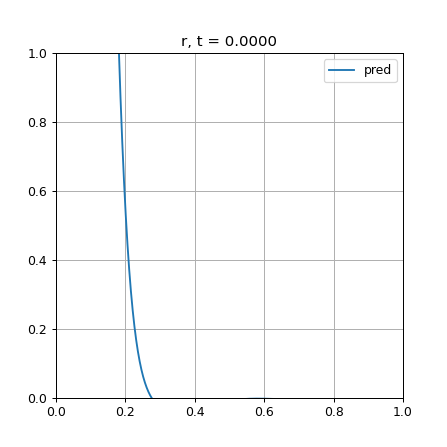

In [12]:
from matplotlib import animation
%matplotlib notebook

fig, ax = plt.subplots(1, 1, figsize = (5, 5))
lines = []
line, = ax.plot([], [], lw = 1.5, label = "pred")
lines.append(line)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.legend()
ax.grid()
    
def init():
	for line in lines:
		line.set_data([], [])
	return lines

def animate(i):
	r_hat_pred = r_hat_preds[i]
	lines[0].set_data(x_test, r_hat_pred)
	ax.set_title("r, t = {:.4f}".format(t_test[i]))
	return lines

anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 100, blit = True)
plt.show()

<IPython.core.display.Javascript object>


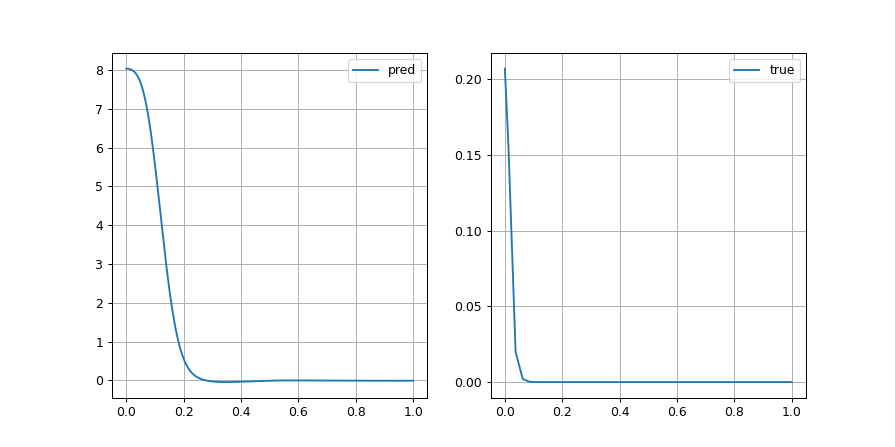

In [18]:
from scipy.io import loadmat
data = loadmat("epsilon_1.0.mat")
x_true_, u_true = data["x"], data["u"]
x_true = np.zeros_like(u_true)
x_true[0] = 0; x_true[-1] = 1
x_true[1:-1] = x_true_

f, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].plot(x_test, r_hat_preds[-1], label = "pred")
ax[1].plot(x_true, u_true, label = "true")
for i in range(2):
	ax[i].legend()
	ax[i].grid()
plt.show()

In [ ]:
# from matplotlib import animation
# %matplotlib notebook

# fig, ax = plt.subplots(2, 3, figsize = (15, 10))
# lines = []
# for i in range(2):
# 	for j in range(3):
# 		line, = ax[i][j].plot([], [], lw = 1.5, label = "pred")
# 		lines.append(line)
# 		ax[i][j].set_xlim([-1, 1])
# 		ax[i][j].set_ylim([-5, 5])
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# ax[0][0].set_ylim([0.9, 2.1])
# ax[1][0].set_ylim([-0.1, 1.0])
    
# def init():
# 	for line in lines:
# 		line.set_data([], [])
# 	return lines

# def animate(i):
# 	u_pred, v_pred = u_preds[i], v_preds[i]
# 	du_dx_pred, dv_dx_pred = du_dx_preds[i], dv_dx_preds[i]
# 	du_dt_pred, dv_dt_pred = du_dt_preds[i], dv_dt_preds[i]
# # 	u_true, v_true = np.real(uv_true[i, :]), np.imag(uv_true[i, :])
	
# 	lines[0].set_data(x_test, u_pred)
# 	ax[0][0].set_title("u, t = {:.4f}".format(t_test[i]))
# 	lines[1].set_data(x_test, du_dx_pred)
# 	ax[0][1].set_title("du_dx, t = {:.4f}".format(t_test[i]))
# 	lines[2].set_data(x_test, du_dt_pred)
# 	ax[0][2].set_title("du_dt, t = {:.4f}".format(t_test[i]))
    
# 	lines[3].set_data(x_test, v_pred)
# 	ax[1][0].set_title("v, t = {:.4f}".format(t_test[i]))
# 	lines[4].set_data(x_test, dv_dx_pred)
# 	ax[1][1].set_title("dv_dx, t = {:.4f}".format(t_test[i]))
# 	lines[5].set_data(x_test, dv_dt_pred)
# 	ax[1][2].set_title("dv_dt, t = {:.4f}".format(t_test[i]))

# 	return lines

# anim = animation.FuncAnimation(fig, animate, frames = len(t_test), interval = 50, blit = True)
# plt.show()

In [ ]:
# from scipy.io import loadmat
# data = loadmat("epsilon_0.49.mat")
# x_true, u_true, v_true = data["x"], data["u"], data["v"]

# f, ax = plt.subplots(1, 2, figsize = (12, 5))
# ax[0].plot(x_test, u_preds[-1], label = "pred")
# ax[0].plot(x_true, u_true, label = "true")
# ax[0].set_title("u, t = {:.2f}".format(t_test[-1]))
# ax[1].plot(x_test, v_preds[-1], label = "pred")
# ax[1].plot(x_true, v_true, label = "true")
# ax[1].set_title("v, t = {:.2f}".format(t_test[-1]))
# for i in range(2):
# 	ax[i].legend()
# 	ax[i].grid()
# plt.show()

In [ ]:
# x = jnp.linspace(*domain[:, 0], 10000).reshape((-1, 1))
# t = jnp.zeros_like(x)
# xt = jnp.hstack([x, t])


# # direct_params_ = direct_params
# direct_params_ = get_params(opt_state)
# duv_dxt = jacobian(direct_params_, xt)
# du_dt, dv_dt = duv_dxt[:, 0:1, 1], duv_dxt[:, 1:2, 1]
# du_dx, dv_dx = duv_dxt[:, 0:1, 0], duv_dxt[:, 1:2, 0]
# duv_dxxtt = hessian(direct_params_, xt)
# du_dxx, dv_dxx = duv_dxxtt[:, 0:1, 0, 0], duv_dxxtt[:, 1:2, 0, 0] 
# uv = model(direct_params_, xt)
# u, v = uv[:, 0:1], uv[:, 1:2]
# loss_c1 = epsilon*du_dt + 0.5*epsilon**2*dv_dxx - V*v
# loss_c2 = epsilon*dv_dt - 0.5*epsilon**2*du_dxx + V*u

# du0_dx, dv0_dx = du0_dx_fn(xt), dv0_dx_fn(xt)
# du0_dxx, dv0_dxx = du0_dxx_fn(xt), dv0_dxx_fn(xt)
# u0, v0 = u0_fn(xt[:, 0:1], xt[:, 1:2]), v0_fn(xt[:, 0:1], xt[:, 1:2])
# du0_dt = 1.0/epsilon*(V*v0 - epsilon**2/2*dv0_dxx)
# dv0_dt = 1.0/epsilon*(epsilon**2/2*du0_dxx - V*u0)
# loss_c10 = epsilon*du0_dt + 0.5*epsilon**2*dv0_dxx - V*v0
# loss_c20 = epsilon*dv0_dt - 0.5*epsilon**2*du0_dxx + V*u0

# %matplotlib inline
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams["text.usetex"] = True

# f, ax = plt.subplots(2, 5, figsize = (20, 10))
# i, j = 0, 0
# ax[i][j].plot(x, du_dt, label = "pred")
# ax[i][j].plot(x, du0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial t}$")
# i = 1
# ax[i][j].plot(x, dv_dt, label = "pred")
# ax[i][j].plot(x, dv0_dt, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial t}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dx, label = "pred")
# ax[i][j].plot(x, du0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial u}{\partial x}$")
# i = 1
# ax[i][j].plot(x, dv_dx, label = "pred")
# ax[i][j].plot(x, dv0_dx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial v}{\partial x}$")
# i, j = 0, j+1
# ax[i][j].plot(x, du_dxx, label = "pred")
# ax[i][j].plot(x, du0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 u}{\partial x^2}$")
# i = 1
# ax[i][j].plot(x, dv_dxx, label = "pred")
# ax[i][j].plot(x, dv0_dxx, label = "true")
# ax[i][j].set_title(r"$\frac{\partial^2 v}{\partial x^2}$")
# i, j = 0, j+1
# ax[i][j].plot(x, u, label = "pred")
# ax[i][j].plot(x, u0, label = "true")
# ax[i][j].set_title(r"$u$")
# i = 1
# ax[i][j].plot(x, v, label = "pred")
# ax[i][j].plot(x, v0, label = "true")
# ax[i][j].set_title(r"$v$")
# i, j = 0, j+1
# ax[i][j].plot(x, loss_c1, label = "pred")
# ax[i][j].plot(x, loss_c10, label = "true")
# ax[i][j].set_title(r"loss c1")
# i = 1
# ax[i][j].plot(x, loss_c2, label = "pred")
# ax[i][j].plot(x, loss_c20, label = "true")
# ax[i][j].set_title(r"loss c2")

# for i in range(2):
# 	for j in range(5):
# 		ax[i][j].legend()
# 		ax[i][j].grid()
# plt.show()

In [ ]:
get_params(opt_state)

In [ ]:
du_dxx

In [ ]:
du0_dx_fn(jnp.array([[-0.25, 0.0], [0.25, 0.0]]))